In [2]:
import pandas as pd
import numpy as np
import random

# Importing dataset

In [346]:
datasets = [
    "data/opsahl-ucsocial/out.opsahl-ucsocial",
    "data/emails/email-Eu-core-temporal_processed.txt",
    "data/soc-sign-bitcoinalpha/out.soc-sign-bitcoinalpha",
    "data/soc-sign-bitcoinotc/out.soc-sign-bitcoinotc",
    "data/munmun_digg_reply/out.munmun_digg_reply",
    "data/sx-mathoverflow/out.sx-mathoverflow"
]
dataset_names = [
    "opsahl-ucsocial",
    "email-Eu-core-temporal",
    "soc-sign-bitcoinalpha",
    "soc-sign-bitcoinotc",
    "munmun_digg_reply",
    "sx-mathoverflow"
]
skiprows = [[0, 1], [], [0], [0], [0], [0]]
current = 3 # 0 1 2 3 4 5
graph = pd.read_csv(
    datasets[current],
    names=["_from", "_to", "_weight", "_timestamp"],
    sep=" |\t",
    engine ='python',
    skiprows=skiprows[current]
)
V = np.unique(graph["_from"]._append(graph["_to"])).astype(int)
V.sort()
n = V.size
volume = graph["_timestamp"].size
print(f"{n = }, {volume = }")


n = 5881, volume = 35592


# Tools

In [56]:
def write_results(number_of_task: int, lines: list[str]):
    """Writes results to .txt files.
    Args:
        number_of_task (int): 1 or 2.
        lines (list[str]): Lines to write.
    """
    with open(f"results/task_{number_of_task}/dataset_{current}.txt", "w") as f:
        f.writelines(line + '\n' for line in lines)

# Chapter 1

## Preparing static graph

In [39]:
graph_static = dict.fromkeys(V)
for u in V:
    graph_static[u] = set()
for _index, _from, _to, _weight, _timestamp in graph.itertuples():
    if _from == _to:
        continue
    if not _to in V:
        print(_from, _to)
    graph_static[_from].add(_to)
    graph_static[_to].add(_from)


## Task 1.1

### |E| and density

In [40]:
E_count = 0
for u in graph_static.keys():
    E_count += len(graph_static[u])
E_count //= 2
#print(E_count)

density = E_count * 2 / (n * (n - 1))
#print(density)

### Connectivity components

In [41]:
V_to_visit = set(V)
connectivity_components = []
while(V_to_visit):
    V_seen = set()
    queue = []
    for u in V_to_visit:
        queue.append(u)
        V_seen.add(u)
        break
    while queue:
        u = queue.pop()
        u_adjacent_to_visit = graph_static[u].difference(V_seen)
        for v in u_adjacent_to_visit:
            V_seen.add(v)
            queue.append(v)
    V_to_visit = V_to_visit.difference(V_seen)
    connectivity_components.append(V_seen)

sizes = list(map(lambda x: len(x), connectivity_components))
max_component_size = max(sizes)
max_connectivity_component_index = sizes.index(max_component_size)
proportion = max_component_size / len(V)
#print(f"{max_val = }, {max_connectivity_component_index = }, {proportion = }")


In [42]:
# 1.1
print("|V| = %i, |E| = %i, p = %f, number of components = %i, max component size = %i, max component proportion = %f"
      % (n, E_count, density, len(connectivity_components), max_component_size, proportion))


|V| = 24818, |E| = 187986, p = 0.000610, number of components = 104, max component size = 24668, max component proportion = 0.993956


## Task 1.2

### Diameter, radius, all distances

In [43]:
component = list(connectivity_components[max_connectivity_component_index])
distances = [0] * (n + 2)
diameter = 0
radius = n + 1
n_limit = 10000
if n < n_limit:
    for start in component:
        distances_tmp = dict.fromkeys(V, n + 1)
        V_visited = set()
        queue = [(start, 0)]
        queued = set([start])
        depth = 0
        u = start
        while queued:
            (u, depth) = queue.pop(0)
            queued.remove(u)
            V_visited.add(u)
            u_adjacent_to_visit = graph_static[u].difference(V_visited)
            for v in u_adjacent_to_visit:
                distances_tmp[v] = min(distances_tmp[v], depth + 1)
                if v not in queued:
                    queue.append((v, depth + 1))
                    queued.add(v)
        for u in V:
            if u > start:
                distances[distances_tmp[u]] += 1
        diameter = max(diameter, depth)
        radius = min(radius, depth)
        if not start % 10:
            #print(start, "/", n)
            pass
all_dist = 0
for i in range(diameter + 1):
    all_dist += distances[i]
print(all_dist, "=", max_component_size * (max_component_size - 1) // 2,
      all_dist == max_component_size * (max_component_size - 1) // 2)


0 = 304242778 False


### 90 percentille

In [44]:
#percentile_90 = np.percentile(all_distances, 90)
percentile_90_ind = int(0.9 * all_dist)
percentile_90 = 0
ind_tmp = 0
for i in range(diameter + 1):
    ind_tmp += distances[i]
    if ind_tmp >= percentile_90_ind:
        percentile_90 = i
        break

### Distance matrix for a set of vertices function definition

In [45]:
def calculate_matrix(vertices):

    vertices_list = list(vertices)

    distances = []
    distance_matrix = dict()
    for u in vertices_list:
        distance_matrix[u] = dict()
        for v in vertices_list:
            if u != v:
                distance_matrix[u][v] = n + 1

    for start in vertices_list:
        V_to_calculate = set(vertices)
        V_to_calculate.discard(start)
        V_visited = set()
        queue = [(start, 0)]
        queued = set([start])
        max_depth = 0
        while queued and V_to_calculate:
            u, depth = queue.pop(0)
            max_depth = max(max_depth, depth)
            queued.discard(u)
            V_visited.add(u)
            u_adjacent_to_visit = graph_static[u].difference(V_visited)
            for v in u_adjacent_to_visit:
                if v in V_to_calculate:
                    distance = distance_matrix[start][v]
                    if depth + 1 < distance:
                        distance_matrix[start][v] = depth + 1
                        distance_matrix[v][start] = depth + 1
                        V_to_calculate.discard(v)
                if v not in queued:
                    queue.append((v, depth + 1))
                    queued.add(v)
    
    for u in vertices_list:
        for v in vertices_list:
            if u > v:
                distances.append(distance_matrix[u][v])
    eccentricities = dict()
    for u in distance_matrix:
        eccentricities[u] = max(distance_matrix[u].values())

    return (distance_matrix, eccentricities, distances)


### Diameter, radius, percentille from random vertices

In [46]:
component = list(connectivity_components[max_connectivity_component_index])
diameter_from_random_500 = 0
radius_from_random_500 = 0
percentile_90_from_random_500 = 0
diameter_from_random_1000 = 0
radius_from_random_1000 = 0
percentile_90_from_random_1000 = 0
if n >= 500:
    random_500_vertices = sorted(random.sample(component, 500))
    random_500_matrix, random_500_eccentricities, random_500_distances = calculate_matrix(
        random_500_vertices)
    diameter_from_random_500 = max(random_500_eccentricities.values())
    radius_from_random_500 = min(random_500_eccentricities.values())
    percentile_90_from_random_500 = np.percentile(random_500_distances, 90)
    print(f"{diameter_from_random_500 = }, {radius_from_random_500 = }, {percentile_90_from_random_500 = }")
if n >= 1000:
    random_1000_vertices = sorted(random.sample(component, 1000))
    random_1000_matrix, random_1000_eccentricities, random_1000_distances = calculate_matrix(
        random_1000_vertices)
    diameter_from_random_1000 = max(random_1000_eccentricities.values())
    radius_from_random_1000 = min(random_1000_eccentricities.values())
    percentile_90_from_random_1000 = np.percentile(random_1000_distances, 90)
    print(f"{diameter_from_random_1000 = }, {radius_from_random_1000 = }, {percentile_90_from_random_1000 = }")

                    

diameter_from_random_500 = 6, radius_from_random_500 = 4, percentile_90_from_random_500 = 4.0
diameter_from_random_1000 = 7, radius_from_random_1000 = 4, percentile_90_from_random_1000 = 4.0


### Diameter, radius, percentille from snowball vertices

In [47]:
component = list(connectivity_components[max_connectivity_component_index])

def snowball(limit, component):
    vertices = set(random.sample(component, 2))
    while len(vertices) < limit:
        for v in vertices:
            if len(vertices) < limit:
                vertices = vertices.union(graph_static[v])
    return sorted(list(vertices))

diameter_from_snowball_500 = 0
radius_from_snowball_500 = 0
percentile_90_from_snowball_500 = 0
diameter_from_snowball_1000 = 0
radius_from_snowball_1000 = 0
percentile_90_from_snowball_1000 = 0
if n >= 500:
    snowball_500_vertices = snowball(500, component)
    snowball_500_matrix, snowball_500_eccentricities, snowball_500_distances = calculate_matrix(
        snowball_500_vertices)
    diameter_from_snowball_500 = max(snowball_500_eccentricities.values())
    radius_from_snowball_500 = min(snowball_500_eccentricities.values())
    percentile_90_from_snowball_500 = np.percentile(snowball_500_distances, 90)
    print(f"{diameter_from_snowball_500 = }, {radius_from_snowball_500 = }, {percentile_90_from_snowball_500 = }")

if n >= 1000:
    snowball_1000_vertices = snowball(1000, component)
    snowball_1000_matrix, snowball_1000_eccentricities, snowball_1000_distances = calculate_matrix(
        snowball_1000_vertices)
    diameter_from_snowball_1000 = max(snowball_1000_eccentricities.values())
    radius_from_snowball_1000 = min(snowball_1000_eccentricities.values())
    percentile_90_from_snowball_1000 = np.percentile(snowball_1000_distances, 90)
    print(f"{diameter_from_snowball_1000 = }, {radius_from_snowball_1000 = }, {percentile_90_from_snowball_1000 = }")


diameter_from_snowball_500 = 4, radius_from_snowball_500 = 2, percentile_90_from_snowball_500 = 2.0
diameter_from_snowball_1000 = 5, radius_from_snowball_1000 = 3, percentile_90_from_snowball_1000 = 3.0


In [48]:
# 1.2
print("diameter = %i, raduis = %i, percentile_90 = %i" 
      % (diameter, radius, percentile_90))

diameter = 0, raduis = 24819, percentile_90 = 0


## Task 1.3

In [49]:
component = list(connectivity_components[max_connectivity_component_index])

Cl = dict()
for u in component:
    u_neighbors = graph_static[u]

    if len(u_neighbors) < 2:
        Cl[u] = 0
        continue

    Lu_doubled = 0
    for neighbor in u_neighbors:
        Lu_doubled += len(graph_static[neighbor].intersection(u_neighbors))
    Cl[u] = Lu_doubled / (len(u_neighbors) * (len(u_neighbors) - 1))

Cl_average = sum(Cl.values()) / len(Cl.values())

In [50]:
#1.3
print("Cl_average = %f" % (Cl_average))

Cl_average = 0.313994


## Task 1.4

In [51]:
R1 = 0
R2 = 0
R3 = 0
Re = 0
for u in V:
    ku = len(graph_static[u])
    R1 += ku
    R2 += ku**2
    R3 += ku**3
    for v in graph_static[u]:
        kv = len(graph_static[v])
        Re += ku * kv
degree_associativity = (Re * R1 - R2**2) / (R3 * R1 - R2**2)

In [52]:
print("Degree associativity = %f" % (degree_associativity))

Degree associativity = -0.215181


## Writing results down for task 1

In [53]:
lines = [
    "Task 1.1",
    f"Число вершин: |V| = {n}",
    f"Число ребер: |E| = {E_count}",
    f"Плотность: p = {density}",
    f"Число компонент слабой связности: {len(connectivity_components)}",
    f"Доля вершин в максимальной по мощности компоненте слабой связности: {proportion}",
    "\nTask 1.2",
    f"Оценки для 500 вершин (случайные вершины): {diameter_from_random_500 = }, {radius_from_random_500 = }, {percentile_90_from_random_500 = }",
    f"Оценки для 1000 вершин (случайные вершины): {diameter_from_random_1000 = }, {radius_from_random_1000 = }, {percentile_90_from_random_1000 = }",
    f"Оценки для 500 вершин (снежный ком): {diameter_from_snowball_500 = }, {radius_from_snowball_500 = }, {percentile_90_from_snowball_500 = }",
    f"Оценки для 1000 вершин (снежный ком): {diameter_from_snowball_1000 = }, {radius_from_snowball_1000 = }, {percentile_90_from_snowball_1000 = }",
    f"Вычисленные значения: {diameter = }, {radius = }, {percentile_90 = }" if n < n_limit else "Для этого датасета диаметр, радиус и 90-ый перцентиль будут вычисляться долго",
    "\nTask 1.3",
    f"Cредний кластерный коэффициент сети: {Cl_average = }",
    "\nTask 1.4",
    f"Коэффициент корреляции Пирсона: {degree_associativity}"
]
write_results(1, lines)

In [54]:
assert False

AssertionError: 

# Chapter 2

### Preparing data structures

In [347]:
t_min = graph["_timestamp"].min()
t_max = graph["_timestamp"].max()
s = 2.0 / 3.0
t_s = t_min + (t_max - t_min) * s
l = 0.2

t_matrix = dict.fromkeys(V)
for u in V:
    t_matrix[u] = dict()

for _index, _from, _to, _weight, _timestamp in graph.itertuples():
    if _from == _to or _timestamp > t_s:
        continue
    
    if t_matrix[_from].get(_to) is not None: 
        t_matrix[_from][_to].append(_timestamp)
    else:
        t_matrix[_from][_to] = [_timestamp]
    
    if t_matrix[_to].get(_from) is not None: 
        t_matrix[_to][_from].append(_timestamp)
    else:
        t_matrix[_to][_from] = [_timestamp]

graph_static = dict.fromkeys(V)
for u in V:
    graph_static[u] = set()
for _index, _from, _to, _weight, _timestamp in graph.itertuples():
    if _from == _to:
        continue
    if not _to in V:
        print(_from, _to)
    graph_static[_from].add(_to)
    graph_static[_to].add(_from)
    

## Features

### Static features functions definitions

In [348]:
def get_static_topological_features(u, v):
    gamma_u = set(t_matrix[u].keys())
    gamma_v = set(t_matrix[v].keys())
    
    intersection_u_v = gamma_u.intersection(gamma_v)
    
    CN_static = len(intersection_u_v)
    JC_static = CN_static / len(gamma_u.union(gamma_v))
    PA_static = len(gamma_u) * len(gamma_v)
    AA_static = sum(
        [1.0 / np.log(len(set(t_matrix[z].keys()))) for z in intersection_u_v]
    )
    return CN_static, AA_static, JC_static, PA_static

### Temporal features functions definitions

#### Step 1: Temporal weighting

In [349]:
def get_temporal_weighting(l, t):
    time_var = (t - t_min) / (t_s - t_min)
    w_linear = l + (1 - l) * time_var
    w_exponential = l + (1 - l) * (np.exp(3 * time_var) - 1) / (np.exp(3) - 1)
    w_square_root = l + (1 - l) * np.sqrt(time_var)
    return [w_linear, w_exponential, w_square_root]
    

#### Step 2: Aggregation of node activity

In [350]:
class AggregationOfNodeActivity:  
    @staticmethod
    def zeroth_quantile(weights):
        return np.quantile(weights, 0)
    
    @staticmethod
    def first_quantile(weights):
        return np.quantile(weights, 0.25)
    
    @staticmethod
    def second_quantile(weights):
        return np.quantile(weights, 0.50)
    
    @staticmethod
    def third_quantile(weights):
        return np.quantile(weights, 0.75)
    
    @staticmethod
    def fourth_quantile(weights):
        return np.quantile(weights, 1)
    
    @staticmethod
    def get_sum(weights):
        return sum(weights)
    
    @staticmethod
    def get_mean(weights):
        return np.mean(weights)
    
    @staticmethod
    def aggregate(weights):
        return [
            AggregationOfNodeActivity.zeroth_quantile(weights),
            AggregationOfNodeActivity.first_quantile(weights),
            AggregationOfNodeActivity.second_quantile(weights),
            AggregationOfNodeActivity.third_quantile(weights),
            AggregationOfNodeActivity.fourth_quantile(weights),
            AggregationOfNodeActivity.get_sum(weights),
            AggregationOfNodeActivity.get_mean(weights)
        ]

#### Step 3: Combining node activity

In [351]:
class CombiningNodeActivity:
    @staticmethod
    def get_sum(a, b):
        return a + b
    
    @staticmethod
    def get_absolute_differrence(a, b):
        return abs(a - b)
    
    @staticmethod
    def get_minimum(a, b):
        return min(a, b)
    
    @staticmethod
    def get_maximum(a, b):
        return max(a, b)
    
    @staticmethod
    def combine(u_list, v_list):
        feature = []
        for a, b in zip(u_list, v_list):
            feature.append(CombiningNodeActivity.get_sum(a, b))
            feature.append(CombiningNodeActivity.get_absolute_differrence(a, b))
            feature.append(CombiningNodeActivity.get_minimum(a, b))
            feature.append(CombiningNodeActivity.get_maximum(a, b))
        return feature



### Calculating features

#### Step 1 Calculating temporal weights

In [352]:
for vt in t_matrix.values():
    for v, times in vt.items():
        for i, t in enumerate(times):
            vt[v][i] = get_temporal_weighting(l, t)

#### Step 2 Calculating Node Activity

In [353]:
node_activity_feature_graph = dict()
for u in V:
    node_activity_feature_graph[u] = list()

for u, vt in t_matrix.items():
    if len(vt) == 0:
        continue
    linears = []
    exponentials = []
    squares = []
    for v, weights in vt.items():
        if not linears:
            linears = [w[0] for w in weights]
            exponentials = [w[1] for w in weights]
            squares = [w[2] for w in weights]
            continue
        linears.extend([w[0] for w in weights])
        exponentials.extend([w[1] for w in weights])
        squares.extend([w[2] for w in weights])
    for weights in (linears, exponentials, squares):
        node_activity_feature_graph[u].extend(
            AggregationOfNodeActivity.aggregate(weights)
        )


#### Step 3.1 Choosing pairs of nodes for feature calculating

##### 3.1.1 All pairs at distance two

In [354]:
pairs = set()

for u in V:
    u_adj = set(t_matrix[u].keys())
    for v in V:
        if u >= v or v in u_adj:
            continue
        v_adj = set(t_matrix[v].keys())
        if v_adj.intersection(u_adj):
            pairs.add((u, v))


##### 3.1.2 Lables for pairs

In [355]:
connecting = list()
non_connecting = list()

for u, v in pairs:
    if v in graph_static[u]:
        connecting.append((u, v))
    else:
        non_connecting.append((u, v))

print(len(connecting), len(non_connecting))

821 1021273


##### 3.1.3 Sampling with replacement

In [356]:
m = 10000
x_y = random.choices(connecting, k=m)
x_n = random.choices(non_connecting, k=m)

x_pairs = list(x_y)
x_pairs.extend(x_n)

y_all = [1] * m
y_all.extend([0] * m)


#### Step 3.2 Calculating static and temporal features for sampled pairs

In [357]:
features_temporal = dict.fromkeys(list(set(x_y).union(set(x_n))))
features_static = dict.fromkeys(list(set(x_y).union(set(x_n))))

for u, v in features_temporal.keys():
    features_static[(u, v)] = get_static_topological_features(u, v)
    features_temporal[(u, v)] = CombiningNodeActivity.combine(
        node_activity_feature_graph[u], node_activity_feature_graph[v]
    )

### Preparing Dataset for regression

In [358]:
x_all_static = []
x_all_temporal = []

for pair in x_pairs:
    x_all_static.append(features_static[pair])
    x_all_temporal.append(features_temporal[pair])

y_train = []
y_test = []
x_train_static = []
x_test_static = []
x_train_temporal = []
x_test_temporal = []
x_pairs_train = []
x_pairs_test = []

for i in range(2 * m):
    if random.random() > 0.75:
        y_test.append(y_all[i])
        x_test_static.append(x_all_static[i])
        x_test_temporal.append(x_all_temporal[i])
        x_pairs_test.append(x_pairs[i])
    else:
        y_train.append(y_all[i])
        x_train_static.append(x_all_static[i])
        x_train_temporal.append(x_all_temporal[i])
        x_pairs_train.append(x_pairs[i])


## Regression

In [359]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn import metrics

#### Regression for temporal features

In [360]:
model_temporal = LogisticRegression(max_iter=10000)
model_temporal.fit(x_train_temporal, y_train)
y_pred_proba_temporal = model_temporal.predict_proba(x_test_temporal)
y_pred_temporal = model_temporal.predict(x_test_temporal)
print(metrics.accuracy_score(y_test, y_pred_temporal))

0.9219123505976096


#### Regression for static features

In [361]:
model_static = LogisticRegression(max_iter=1000)
model_static.fit(x_train_static, y_train)
y_pred_proba_static = model_static.predict_proba(x_test_static)
y_pred_static = model_static.predict(x_test_static)
print(metrics.accuracy_score(y_test, y_pred_static))

0.8123505976095617


### ROC AUC curve

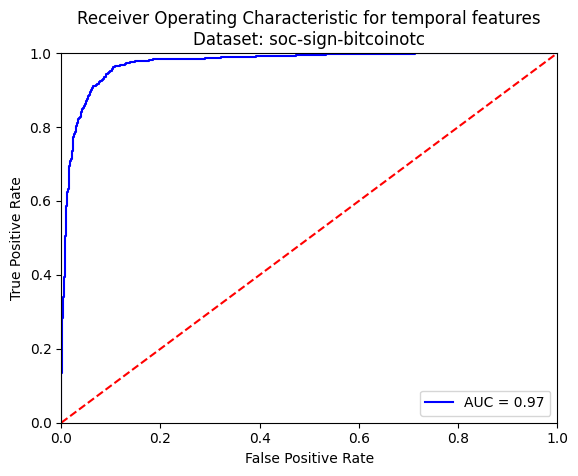

In [362]:
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, y_pred_proba_temporal[:, 1])
roc_auc_t = metrics.auc(fpr_t, tpr_t)

plt.title('Receiver Operating Characteristic for temporal features\n' +
          "Dataset: " + dataset_names[current])
plt.plot(fpr_t, tpr_t, 'b', label='AUC = %0.2f' % roc_auc_t)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("results/task_2/dataset_"+str(current)+"/roct"+str(current))
plt.show()



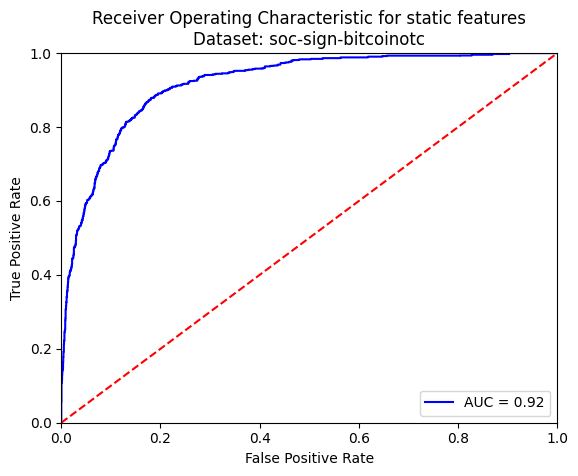

In [363]:
fpr_s, tpr_s, thresholds_s = metrics.roc_curve(y_test, y_pred_proba_static[:, 1])
roc_auc_s = metrics.auc(fpr_s, tpr_s)

plt.title('Receiver Operating Characteristic for static features\n' +
          "Dataset: " + dataset_names[current])
plt.plot(fpr_s, tpr_s, 'b', label='AUC = %0.2f' % roc_auc_s)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("results/task_2/dataset_"+str(current)+"/rocs"+str(current))
plt.show()


### Confusion Matrix

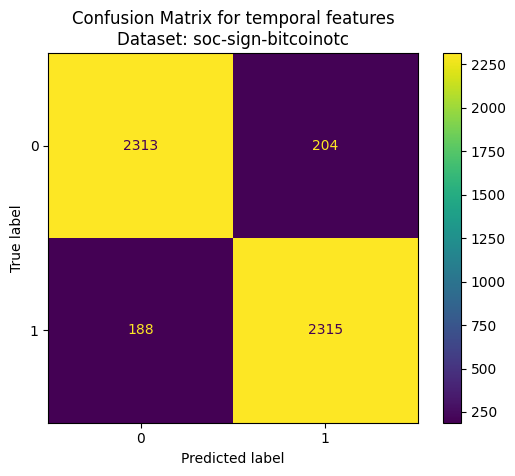

In [364]:
cm_t = metrics.confusion_matrix(
    y_test, y_pred_temporal, labels=model_temporal.classes_)
disp_t = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_t, display_labels=model_temporal.classes_)
disp_t.plot()
disp_t.ax_.set_title('Confusion Matrix for temporal features\n' +
                   "Dataset: " + dataset_names[current])
plt.savefig("results/task_2/dataset_"+str(current)+"/cmt"+str(current))
plt.show()


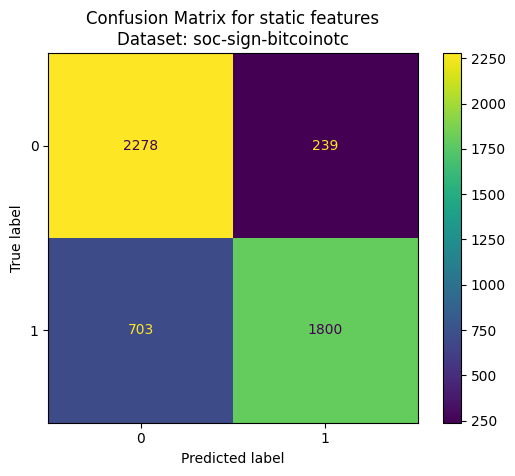

In [365]:
cm_s = metrics.confusion_matrix(
    y_test, y_pred_static, labels=model_static.classes_)
disp_s = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm_s, display_labels=model_static.classes_)
disp_s.plot()
disp_s.ax_.set_title('Confusion Matrix for static features\n' +
                   "Dataset: " + dataset_names[current])
plt.savefig("results/task_2/dataset_"+str(current)+"/cms"+str(current))
plt.show()


### Other Metrics

In [366]:
accuracy_t = metrics.accuracy_score(y_test, y_pred_temporal)
accuracy_s = metrics.accuracy_score(y_test, y_pred_static)

precision_t = metrics.precision_score(y_test, y_pred_temporal)
precision_s = metrics.precision_score(y_test, y_pred_static)

recall_t = metrics.recall_score(y_test, y_pred_temporal)
recall_s = metrics.recall_score(y_test, y_pred_static)

f1_t = metrics.f1_score(y_test, y_pred_temporal)
f1_s = metrics.f1_score(y_test, y_pred_static)

log_loss_t = metrics.log_loss(y_test, y_pred_temporal)
log_loss_s = metrics.log_loss(y_test, y_pred_static)

mcc_t = metrics.matthews_corrcoef(y_test, y_pred_temporal)
mcc_s = metrics.matthews_corrcoef(y_test, y_pred_static)

## Writing results down for task 2

In [367]:
lines = [
    "Temporal:",
    "Accuracy score = %f" % (accuracy_t),
    "Precision score = %f" % (precision_t),
    "Recall score = %f" % (recall_t),
    "F1 score = %f" % (f1_t),
    "Log Loss = %f" % (log_loss_t),
    "Matthews Correlation Coefficient = %f" % (mcc_t),
    "AUC = %f" % (roc_auc_t),
    "",
    "Static:",
    "Accuracy score = %f" % (accuracy_s),
    "Precision score = %f" % (precision_s),
    "Recall score = %f" % (recall_s),
    "F1 score = %f" % (f1_s),
    "Log Loss = %f" % (log_loss_s),
    "Matthews Correlation Coefficient = %f" % (mcc_s),
    "AUC = %f" % (roc_auc_s)
]
write_results(2, lines)